## Dataset
Dataset is the main object you will work with directly. Dataset is derived from python’s **dict**, so it inherits (and overrides some of) the methods of dict. In other words it is a collection of key:value pairs, where the key value is the DICOM (group,element) tag (as a Tag object, described below), and the value is a DataElement instance (also described below).

A dataset could be created directly, but you will usually get one by reading an existing DICOM file (it could be a .dcm or a .img file):<!-- TEASER_END -->



In [1]:
import dicom
ds = dicom.read_file("1111.img")

You can display the entire dataset by simply printing its string (str or repr) value:

In [2]:
ds

(0008, 0000) Group Length                        UL: 482
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: '20150710'
(0008, 0013) Instance Creation Time              TM: '152456'
(0008, 0014) Instance Creator UID                UI: 1.2.840.113619.1.131
(0008, 0016) SOP Class UID                       UI: Positron Emission Tomography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113619.2.131.1611270158.1436534696.972053
(0008, 0020) Study Date                          DA: '20150702'
(0008, 0021) Series Date                         DA: '20150702'
(0008, 0022) Acquisition Date                    DA: '20150702'
(0008, 0023) Content Date                        DA: '20150710'
(0008, 0030) Study Time                          TM: '090706'
(0008, 0031) Series Time                         TM: '091216'
(0008, 0032) Acquisit

## Access header data elements
You can access specific data elements by name (DICOM ‘keyword’) or by DICOM tag number:

In [3]:
ds.ManufacturerModelName

'Discovery RX'

In [4]:
ds[0x0008,0x1090].value

'Discovery RX'

In the latter case (using the tag number directly) a DataElement instance is returned, so the .value must be used to get the value.

You can also set values by name (DICOM keyword) or tag number:

In [5]:
ds.PatientID = "12345"
ds.SeriesNumber = 5
ds[0x10,0x10].value = 'Test'

The use of names is possible because PyDicom intercepts requests for member variables, and checks if they are in the DICOM dictionary. It translates the keyword to a (group,element) number and returns the corresponding value for that key if it exists.

If you don’t remember or know the exact tag name, Dataset provides a handy dir() method, useful during interactive sessions at the python prompt:

In [6]:
ds.dir("pat")

['AdditionalPatientHistory',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'PatientAge',
 'PatientBirthDate',
 'PatientGantryRelationshipCodeSequence',
 'PatientID',
 'PatientName',
 'PatientOrientationCodeSequence',
 'PatientOrientationModifierCodeSequence',
 'PatientPosition',
 'PatientSex',
 'PatientSize',
 'PatientWeight']

dir will return any DICOM tag names in the dataset that have the specified string anywhere in the name (case insensitive).

>**NOTE:**
>Calling dir with no string will list all tag names available in the dataset.
>You can also see all the names that pydicom knows about by viewing the _dicom_dict.py file. You could >modify that file to add tags that pydicom doesn’t already know about.

Under the hood, Dataset stores a DataElement object for each item, but when accessed by name (e.g. ds.PatientName) only the value of that DataElement is returned. If you need the whole DataElement (see the DataElement class discussion), you can use Dataset’s data_element() method or access the item using the tag number:

In [7]:
data_element = ds.data_element("PatientsName")  # or data_element = ds[0x10,0x10]
data_element.VR, data_element.value

('PN', 'Test')

## "DataElement" 
The DataElement class is not usually used directly in user code, but is used extensively by Dataset. DataElement is a simple object which stores the following things:

* **tag** – a DICOM tag (as a Tag object)
* **VR** – DICOM value representation – various number and string formats, etc
* **VM** – value multiplicity. This is 1 for most DICOM tags, but can be multiple, e.g. for coordinates. You do not have to specify this, the DataElement class keeps track of it based on value.
* **value** – the actual value. A regular value like a number or string (or list of them), or a Sequence.

To check for the existence of a particular tag before using it, use the in keyword:

In [8]:
"PatientName" in ds

True

To remove a data element from the dataset, use del:

In [9]:
del ds.SoftwareVersions   # or del ds[0x0018, 0x1020]
"SoftwareVersions" in ds

False

## TAG
Using DICOM keywords is the recommended way to access data elements, but you can also use the tag numbers directly. The Tag class is derived from python’s *int*, so in effect, it is just a number with some extra behaviour:

* Tag enforces that the DICOM tag fits in the expected 4-byte (group,element)
* A Tag instance can be created from an int or from a tuple containing the (group,element) separately
* Tag has properties group and element (or elem) to return the group and element portions
* The is_private property checks whether the tag represents a private tag (i.e. if group number is odd).

In [10]:
from dicom.tag import Tag
t1=Tag(0x00100010) # all of these are equivalent
t2=Tag(0x10,0x10)
t3=Tag((0x10, 0x10))
print t1

t1==t2, t1==t3
(True, True)

(0010, 0010)


(True, True)

## Access image data

DICOM Sequences are turned into python lists or strings. Items in the sequence are referenced by number, beginning at index 0 as per python convention. "Sequence" data type is derived from python’s *list*. The only added functionality is to **make string representations prettier**. Otherwise all the usual methods of list like item selection, append, etc. are available. To work with pixel data, the raw bytes are available through the usual tag:

In [11]:
image_data = ds.PixelData
print type(image_data)

<type 'str'>


We then calculate the total dimensions of the NumPy array which are equal to (Number of pixel rows in a slice) x (Number of pixel columns in a slice) x (Number of slices) along the x, y, and z cartesian axes. In this example we are dealing with just a single slice DICOM file, so z=1.

Lastly, we use the PixelSpacing and SliceThickness attributes to calculate the spacing between pixels in the three axes. We store the array dimensions in ConstPixelDims and the spacing in ConstPixelSpacing.

In [12]:
import numpy as np

ConstPixelDims = (int(ds.Rows), int(ds.Columns))
ConstPixelSpacing = (float(ds.PixelSpacing[0]), float(ds.PixelSpacing[1]), float(ds.SliceThickness))

print ConstPixelDims
print ConstPixelSpacing

(128, 128)
(3.125, 3.125, 3.27)


Here, we simply use numpy.arange, ConstPixelDims, and ConstPixelSpacing to calculate axes for this array:

In [13]:
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])

Next, comes the last pydicom part:

In [14]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=ds.pixel_array.dtype)
ArrayDicom[:,:] = ds.pixel_array 

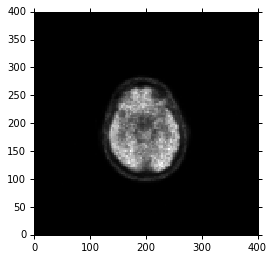

In [15]:
%matplotlib inline
from matplotlib import pyplot, cm

pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, np.flipud(ArrayDicom[:, :]))
pyplot.show()